In [1]:
import torch
import random
import os
import torch.nn as nn
import torchvision
from torchvision import transforms
import PIL
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import matplotlib.cm as cm
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Instantiate the model
resnet = torchvision.models.resnet101(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = True
resnet.fc = nn.Linear(resnet.fc.in_features, 1000)
for param in resnet.fc.parameters():
    param.requires_grad = True

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.backbone = resnet
        self.dense = nn.Linear(1000, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.backbone(x)
        self.embedding = x.detach()  
        x = self.relu(x)
        x = self.dense(x)
        return x

# Create a trained model instance 
model = Model()
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
checkpoint = torch.load('saved_model1.1b.pt')
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [3]:
# Pick some random picture
folder_path = "archive\\chest_xray\\test\\PNEUMONIA\\"
file = os.listdir(folder_path)
random_image = random.choice(file)
img_path = os.path.join(folder_path, random_image)

# Or pick an image from the data
img_path = 'archive\\chest_xray\\test\\PNEUMONIA\\person117_bacteria_557.jpeg'
image = Image.open(img_path).convert('RGB')

In [4]:
# Image transform
image_size = 256
transform = transforms.Compose([
                               transforms.Resize(image_size, antialias=True),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

# stores the tensor that represents the image
img_tensor = transform(image).to(device) 

In [5]:
# Pick the last layer of the nn, the loss and the optimizer
last_layer = model.backbone.layer4[-1]
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(last_layer.parameters(), lr=1e-3, weight_decay=0.005)

In [6]:
# Defines two global scope variables to store our gradients and activations using hooks
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
  global gradients # refers to the variable in the global scope
  print('Backward hook running...')
  gradients = grad_output
  print(f'Gradients size: {gradients[0].size()}') 

def forward_hook(module, args, output):
  global activations # refers to the variable in the global scope
  print('Forward hook running...')
  activations = output
  print(f'Activations size: {activations.size()}')

backward_hook = model.backbone.layer4[-1].register_full_backward_hook(backward_hook, prepend=False)
forward_hook = model.backbone.layer4[-1].register_forward_hook(forward_hook, prepend=False)

In [7]:
# Forward pass: compute the model outputs
# Backward pass: compute gradients of outputs with respect to inputs
input_data = img_tensor.unsqueeze(0)
img_tensor.unsqueeze(0).requires_grad = True
output = model.forward(input_data)
loss_val = loss(output, torch.tensor([1]).to(device))
loss_val.backward()
optimizer.step()

Forward hook running...
Activations size: torch.Size([1, 2048, 8, 8])
Backward hook running...
Gradients size: torch.Size([1, 2048, 8, 8])


In [8]:
pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])

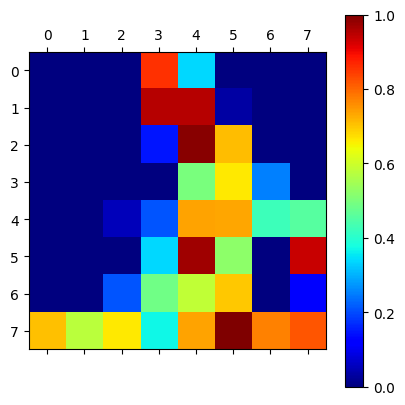

In [9]:
# Weight the channels by corresponding gradients
for i in range(activations.size()[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

# Average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# Relu on top of the heatmap
heatmap = F.relu(heatmap)

# Normalize the heatmap
heatmap /= torch.max(heatmap)

colormap = 'jet' 

plt.matshow(heatmap.cpu().detach(), cmap=colormap)
plt.colorbar()
plt.show()


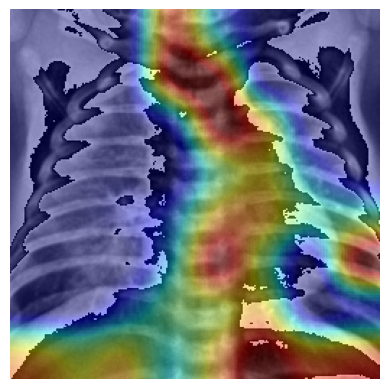

In [10]:
# Create a figure and plot the first image
fig, ax = plt.subplots()

# Removes the axis markers
ax.axis('off')

# First plot the original image
ax.imshow(to_pil_image(img_tensor, mode='RGB'))

# Resize the heatmap to the same size as the input image and defines
# we need heatmap.detach() because it can't be converted to numpy array while
# requiring gradients
overlay = to_pil_image(heatmap.detach(), mode='F').resize((256,256), resample=PIL.Image.BICUBIC)

# Apply any colormap you want
cmap = cm.jet  

# Convert the heatmap to an array and apply the colormap
overlay_np = np.array(overlay)
overlay_colored = (255 * cmap(overlay_np)[:, :, :3]).astype(np.uint8)

# Plot the heatmap on the same axes, 
# but with alpha < 1 (this defines the transparency of the heatmap)
ax.imshow(overlay_colored, alpha=0.4, interpolation='nearest')

plt.show()
